# Notebook for Extension 2
This notebook includes the replication of extension 3 findings from the report.

**Disclaimer**: we do not provide the necessary data or trained models to run the following notebook due to the fact that MIMIC-III data is not public. If you were to gain access to it, train your the necessary models (seen below), and put them in the correct folders, you would be able to run the notebook. Please contact us if you would like to get access to our trained models and explainers.


Concretely what it includes is:
1) Training of the classifier, and ExtremalMask explainer on HMM Modified dataset (or just loading their weights if the models already exist)
2) Perturbing all test set datapoints using the explainer (we do this on the classifier's test set data only because those are the datapoints for which we have mask values)
3) Application of the forward algorithm to calculate log-probabilities of original and perturbed datapoints
4) Plotting the log-probabilities

**Extension 2:** Using a synthetic dataset (HMM modified, Section 3.2.2),we explore the plausibility of the perturbations created with ExtremalMask by testing their probability relative to the original distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
from pytorch_lightning import seed_everything
from tint.attr.models import ExtremalMaskNN
from tint.datasets.hmm_modified import HMM_modified
from tint.models import MLP, RNN
from tint.utils.forward import forward

from experiments.hmm.classifier import StateClassifierNet

In [2]:
# Make the results deterministic
seed = 42
seed_everything(seed=seed, workers=True)

Seed set to 42


42

In [3]:
# Train classifier and Extremal mask explainer, store model weights
%run experiments/hmm/main.py --fold 0 --explainers "extremal_mask" --deterministic --output-file "hmm_modified_results_per_fold.csv" --dataset_name "hmm_modified" --hidden_size 50 

Seed set to 42


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


classifier has loaded the saved weights on hmm_modified dataset with fold = 0, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.
extremal_mask has loaded the saved weights on hmm_modified dataset with fold = 0, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [4]:
### Get data
train_features = np.load("tint/data/hmm/train_features_modified.npz", allow_pickle=True)
test_features = np.load("tint/data/hmm/test_features_modified.npz", allow_pickle=True)

In [5]:
# Transform to tensors, check shape
x_train = th.tensor(train_features)
x_test = th.tensor(test_features)
print(type(x_train), x_train.shape)

<class 'torch.Tensor'> torch.Size([800, 50, 3])


In [6]:
### Get classifier
# Create model
classifier = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=50,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

# Load the state dictionary from the checkpoint file
checkpoint_path = "experiments/checkpoints/hmm_modified_classifier_42_0.ckpt"  ### change path when using different hyperparameters
state_dict = th.load(checkpoint_path)

# Load the state dictionary into the model
classifier.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
# Sanity check for explainer model weights
checkpoint_path = "experiments/checkpoints/hmm_modified_extremal_mask_42_1.0_1.0_0.ckpt"  ### change path when using different hyperparameters

# Load the state dictionary
state_dict = th.load(checkpoint_path)

# Print keys and shapes in the state dictionary
for key, value in state_dict.items():
    print(f"{key}: {value.shape if isinstance(value, th.Tensor) else type(value)}")

net.mask: torch.Size([200, 50, 3])
net.model.0.rnn.weight_ih_l0: torch.Size([9, 3])
net.model.0.rnn.weight_hh_l0: torch.Size([9, 3])
net.model.0.rnn.bias_ih_l0: torch.Size([9])
net.model.0.rnn.bias_hh_l0: torch.Size([9])
net.model.0.rnn.weight_ih_l0_reverse: torch.Size([9, 3])
net.model.0.rnn.weight_hh_l0_reverse: torch.Size([9, 3])
net.model.0.rnn.bias_ih_l0_reverse: torch.Size([9])
net.model.0.rnn.bias_hh_l0_reverse: torch.Size([9])
net.model.1.mlp.Linear_0.weight: torch.Size([3, 6])
net.model.1.mlp.Linear_0.bias: torch.Size([3])


In [8]:
EMNN = ExtremalMaskNN(
    forward_func=classifier,
    model=nn.Sequential(
        RNN(
            input_size=x_train.shape[-1],
            rnn="gru",
            hidden_size=x_train.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_train.shape[-1], x_train.shape[-1]]),
    ),
    batch_size=32,
)

mask = nn.Parameter(th.Tensor([200, 50, 3]))

# Load the state dictionary from the checkpoint file
checkpoint_path = "experiments/checkpoints/hmm_modified_extremal_mask_42_1.0_1.0_0.ckpt"  ### change path when using different hyperparameters
state_dict = th.load(checkpoint_path)

filtered_state_dict_mask = {
    key: value for key, value in state_dict.items() if key == "net.mask"
}
filtered_state_dict_model = {
    key[4:]: value for key, value in state_dict.items() if key != "net.mask"
}

# Load the state dictionary into the model
# print(EMNN.named_parameters)
for name, param in EMNN.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")

EMNN.load_state_dict(filtered_state_dict_model)
# mask.load_state_dict(filtered_state_dict_mask)
mask = state_dict["net.mask"]

Parameter: model.0.rnn.weight_ih_l0, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.weight_hh_l0, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.bias_ih_l0, Shape: torch.Size([9])
Parameter: model.0.rnn.bias_hh_l0, Shape: torch.Size([9])
Parameter: model.0.rnn.weight_ih_l0_reverse, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.weight_hh_l0_reverse, Shape: torch.Size([9, 3])
Parameter: model.0.rnn.bias_ih_l0_reverse, Shape: torch.Size([9])
Parameter: model.0.rnn.bias_hh_l0_reverse, Shape: torch.Size([9])
Parameter: model.1.mlp.Linear_0.weight, Shape: torch.Size([3, 6])
Parameter: model.1.mlp.Linear_0.bias, Shape: torch.Size([3])


(array([21100.,   218.,   229.,   274.,   284.,   358.,   463.,   664.,
         1035.,  5375.]),
 array([-0.00901446,  0.09286568,  0.19474581,  0.29662594,  0.39850608,
         0.50038618,  0.60226631,  0.70414644,  0.80602658,  0.90790671,
         1.00978684]),
 <BarContainer object of 10 artists>)

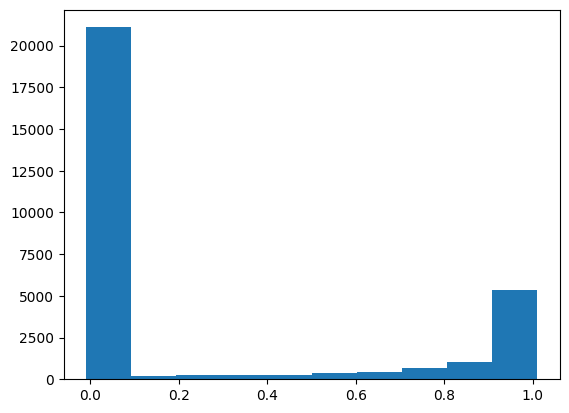

In [9]:
# sanity check - mask values histogram, should be bimodal with modes at 0 and 1, and most values at 0
plt.hist(mask.view(-1))

In [10]:
def perturb(x, m, x_):
    return m * x + (1 - m) * x_

In [11]:
hmm = HMM_modified(n_folds=5, fold=0, seed=seed)  ### change if using different fold

In [12]:
# Apply forward algorithm to get log probabilities of test set datapoints and their perturbations

N = x_test.shape[0]
p = np.zeros(shape=(N, 2))
l = np.zeros(shape=(N, 2))
for i in range(N):
    x = x_test[i].to(th.float32)
    x_ = EMNN.model(x)  ### baselines are 0 by default
    x_p = perturb(x, mask[i], x_)
    x = x.detach().numpy()
    x_p = x_p.detach().numpy()
    p[i, 0] = forward(hmm, x)[1]
    p[i, 1] = forward(hmm, x_p)[1]
    l[i, 0] = np.log(p[i, 0])
    l[i, 1] = np.log(p[i, 1])

print(f"mean probs: {np.mean(p, axis=0)}")
print(f"mean log probs: {np.mean(l, axis=0)}")

mean probs: [2.08896713e-79 9.69643671e-72]
mean log probs: [-211.23392499 -174.96850949]


Text(0, 0.5, 'logPDF value')

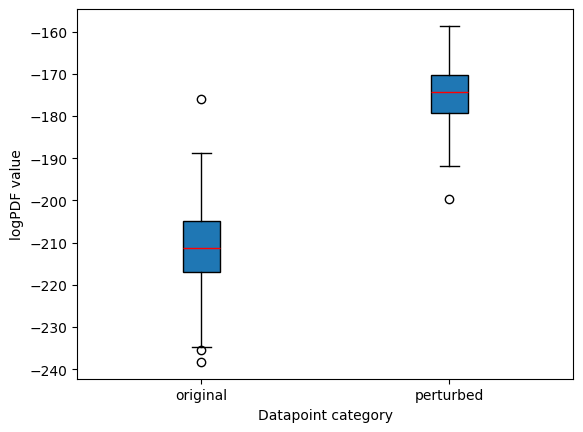

In [14]:
# Visualize results

plt.boxplot(
    l,
    labels=["original", "perturbed"],
    medianprops=dict(color="red"),
    patch_artist="white",
)
# Add labels and title
plt.xlabel("Datapoint category")
plt.ylabel("logPDF value")